In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
cd '/Users/wandawang/Downloads/TalaDataScienceChallengeData'

/Users/wandawang/Downloads/TalaDataScienceChallengeData


In [3]:
callLog = pd.read_csv('dataScienceChallenge_callLog.csv')
repayment = pd.read_csv('dataScienceChallenge_repayment.csv', parse_dates=['signup_date','disbursement_date']) 

In [4]:
#Feature Engineering

In [5]:
#Time 
callLog['local_timestamp'] = pd.to_datetime(callLog['local_timestamp'])
callLog['wkD_week'] = callLog['local_timestamp'].dt.dayofweek
callLog['wkNo_year'] = callLog['local_timestamp'].dt.week
callLog['year'] = callLog['local_timestamp'].dt.year
callLog['month'] = callLog['local_timestamp'].dt.month
callLog['day'] = callLog['local_timestamp'].dt.day
callLog['hour'] = callLog['local_timestamp'].dt.hour

twilight = []
morn = []
after = []
eve = []
time_of_day = []
for i in callLog['hour']:
    if i < 6:
        twilight.append(i)
        time_of_day.append('twilight')
    elif 6 <= i < 13:
        morn.append(i)
        time_of_day.append('morning')
    elif 13 <= i < 17:
        after.append(i)
        time_of_day.append('afternoon')
    elif 17 <= i < 25:
        eve.append(i)
        #print(i)
        time_of_day.append('evening')
        
callLog['ToD'] = time_of_day

In [6]:
#Length of contact name
l = []
for i in callLog['contact_name_redacted']:
    if type(i) == str:
        l.append(len(str(i)))
    else:
        l.append(0)        
callLog['len_contact_name'] = l 

#Area Code buckets
area_code = []
for i in callLog['phone_randomized']:
    a = i[:3]
    area_code.append(a)
callLog['area_code'] = area_code

ac = []
for i in callLog['area_code']:
    if '*' in i:
        ac.append('other')
    elif '#' in i:
        ac.append('other')
    elif int(i[0]) < 2:
        ac.append("area_code_<200s")
    elif 2 <= int(i[0]) < 4:
        ac.append("area_code_200s-400s")        
    elif 4 <= int(i[0]) < 6:
        ac.append("area_code_400s-600s")  
    elif 6 <= int(i[0]) < 8:
        ac.append("area_code_600s-800s")
    elif int(i[0]) >= 8:
        ac.append("area_code_>800s")    
callLog['ac'] = ac

In [7]:
#Days between loan signup and disbursement dates

time_difference = repayment['disbursement_date'] - repayment['signup_date']
repayment['days_difference'] = time_difference.dt.days

signup_month = []
for i in repayment['signup_date']:
    a = i.to_pydatetime().month
    signup_month.append(a)
repayment['signup_month'] = signup_month
    
signup_year = []
for i in repayment['signup_date']:
    a = i.to_pydatetime().year
    signup_year.append(a)
repayment['signup_yr'] = signup_year

disburs_month = []
for i in repayment['disbursement_date']:
    a = i.to_pydatetime().month
    disburs_month.append(a)
repayment['disbursement_month'] = disburs_month

In [8]:
#join dataframes
result = pd.merge(callLog,repayment,on='person_id_random',how='right')

#Dummify categorical variables
ac = pd.get_dummies(result['ac'], prefix = 'ac_')
output = result.join(ac)

ToD = pd.get_dummies(result['ToD'], prefix = 'time_of_day_')
output = output.join(ToD)

direction = pd.get_dummies(result['direction'], prefix = 'direction_')
output = output.join(direction)

In [10]:
output.columns

Index(['person_id_random', 'phone_randomized', 'contact_name_redacted',
       'direction', 'duration', 'local_timestamp', 'wkD_week', 'wkNo_year',
       'year', 'month', 'day', 'hour', 'ToD', 'len_contact_name', 'area_code',
       'ac', 'signup_date', 'disbursement_date', 'paid_first_loan',
       'days_difference', 'signup_month', 'signup_yr', 'disbursement_month',
       'ac__area_code_200s-400s', 'ac__area_code_400s-600s',
       'ac__area_code_600s-800s', 'ac__area_code_<200s', 'ac__area_code_>800s',
       'ac__other', 'time_of_day__afternoon', 'time_of_day__evening',
       'time_of_day__morning', 'time_of_day__twilight', 'direction__incoming',
       'direction__missed', 'direction__outgoing', 'direction__unknown'],
      dtype='object')

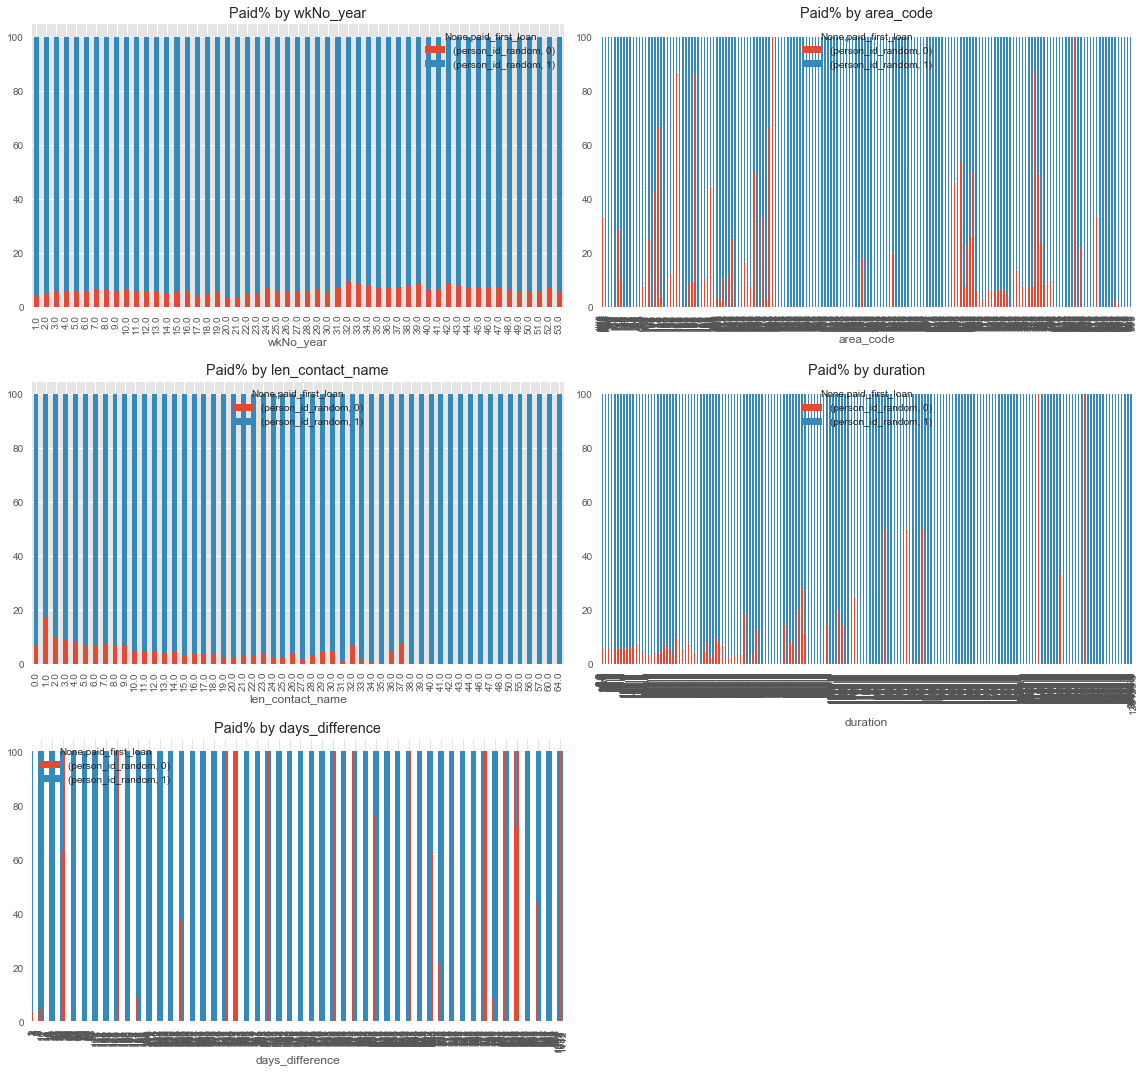

In [11]:
#Visualize features

fig = plt.figure(figsize=(16, 15))

ax1 = plt.subplot("321")
ax1.set_title("Paid% by wkNo_year")
var1 = output.groupby(['wkNo_year','paid_first_loan']).agg({'person_id_random': 'count'})
var1_pct = var1.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var1_pct.unstack().plot(kind='bar',stacked=True, ax = ax1)

ax2 = plt.subplot("322")
ax2.set_title("Paid% by area_code")
var2 = output.groupby(['area_code','paid_first_loan']).agg({'person_id_random': 'count'})
var2_pct = var2.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var2_pct.unstack().plot(kind='bar',stacked=True, ax = ax2)

ax3 = plt.subplot("323")
ax3.set_title("Paid% by len_contact_name")
var3 = output.groupby(['len_contact_name','paid_first_loan']).agg({'person_id_random': 'count'})
var3_pct = var3.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var3_pct.unstack().plot(kind='bar',stacked=True, ax = ax3)

ax4 = plt.subplot("324")
ax4.set_title("Paid% by duration")
var4 = output.groupby(['duration','paid_first_loan']).agg({'person_id_random': 'count'})
var4_pct = var4.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var4_pct.unstack().plot(kind='bar',stacked=True, ax = ax4)

ax5 = plt.subplot("325")
ax5.set_title("Paid% by days_difference")
var5 = output.groupby(["days_difference",'paid_first_loan']).agg({'person_id_random': 'count'})
var5_pct = var5.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
var5_pct.unstack().plot(kind='bar',stacked=True, ax = ax5)

fig.tight_layout()

plt.show()

In [29]:
#Cleanup, drop variables we don't need
res = output.copy()
res = res.drop(['phone_randomized','contact_name_redacted','direction','disbursement_date', 'ac', 
                'local_timestamp','ToD', 'area_code'], axis = 1)

#Replace nulls with 0
res = res.fillna(0)

#train and test set
train_final = res[(res.signup_date < '2015-10-30')]
preds_use= res[(res.signup_date >= '2015-10-30')]

#Cleanup, drop variables we don't need
preds_use = preds_use.drop(['signup_date'], axis = 1)
train_final = train_final.drop(['signup_date'], axis = 1)

In [30]:
target_preds_use = preds_use['paid_first_loan']
target_preds_use = [np.int(x) for x in target_preds_use]

target_train_final = train_final['paid_first_loan']
target_train_final = [np.int(x) for x in target_train_final]

person_id = preds_use['person_id_random']

In [31]:
#deal with unbalanced data
from imblearn.over_sampling import RandomOverSampler
ro = RandomOverSampler()
X_resampled_full, y_resampled_full = ro.fit_sample(train_final, target_train_final)
X_resampled_full = pd.DataFrame(X_resampled_full,columns = train_final.columns)

print ("resample unbalanced data finished")

resample unbalanced data finished


In [32]:
X_resampled_full.paid_first_loan.value_counts()
X_resampled_full.drop(['person_id_random', 'paid_first_loan'],axis=1, inplace=True)

In [33]:
#Cleanup, drop variables we don't need
preds_use.drop(['person_id_random', 'paid_first_loan'],axis=1, inplace=True)
train_final.drop(['person_id_random', 'paid_first_loan'],axis=1, inplace=True)

In [34]:
train_final.columns

Index(['duration', 'wkD_week', 'wkNo_year', 'year', 'month', 'day', 'hour',
       'len_contact_name', 'days_difference', 'signup_month', 'signup_yr',
       'disbursement_month', 'ac__area_code_200s-400s',
       'ac__area_code_400s-600s', 'ac__area_code_600s-800s',
       'ac__area_code_<200s', 'ac__area_code_>800s', 'ac__other',
       'time_of_day__afternoon', 'time_of_day__evening',
       'time_of_day__morning', 'time_of_day__twilight', 'direction__incoming',
       'direction__missed', 'direction__outgoing', 'direction__unknown'],
      dtype='object')

In [ ]:
#feature importance

from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
randomforest = RandomForestClassifier(random_state=24, n_estimators=100)
randomforest.fit(train_final, target_train_final)
# display the relative importance of each attribute
            
top_features = np.array(sorted(zip(map(lambda x: round(x, 4), randomforest.feature_importances_), train_final.columns),
                               reverse=True)[:15])

top_f_name = list(top_features[:,1])
full_data_reduced = train_final[top_f_name]
top_f_score = top_features[:,0]

#plot top n features
%matplotlib inline
plt.figure()
plt.title("Feature Importance")
importance = [np.float(x) for x in top_features[:,0]]
sns.barplot(y=full_data_reduced.columns, x=importance)

In [ ]:
#Random forest without imbalance data oversampling
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score,mean_squared_error

randomforest = RandomForestClassifier(random_state=24,n_estimators=100,oob_score=True)
tree_score = make_scorer(f1_score, greater_is_better=True)

parameters = {'max_depth':[x for x in range(3,10)]}

clf_rf_noros = grid_search.GridSearchCV(estimator=randomforest, param_grid=parameters, cv=5, scoring=tree_score)

clf_rf_noros.fit(train_final,target_train_final)

print ("Random Forest best parameter", clf_rf_noros.best_estimator_)
print ("Random Forest best score", clf_rf_noros.best_score_)  
print ("Random Forest Accuracy:", accuracy_score(target_train_final,clf_rf_noros.predict(train_final)))  
print ('finish Random Forest Train')

In [ ]:
#Model with Oversampling
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()

# USE MSE AS SCORE FUNCTION
tree_score = make_scorer(f1_score, greater_is_better=True)

score_record = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'f1_score', 'accuracy_score'])

kf = cross_validation.KFold(len(train_final), n_folds=5)

train_final.index = range(len(train_final))
target_train_final = pd.DataFrame(target_train_final,columns = ['paid_first_loan])
target_train_final.index = range(len(target_train_final))

for max_depth in range(9, 10):
    print ("running on max_depth:=", max_depth)
    for min_samples_split in range(120,130,20):
        avg_f1_score = 0.0
        avg_accu_score = 0.0 
        for train, test in kf:
            X_train, X_test, Y_train, Y_test = train_final.iloc[train], train_final.iloc[test], target_train_final.iloc[train], target_train_final.iloc[test]
            X_resampled, y_resampled = ros.fit_sample(X_train, Y_train)           
            clf = DecisionTreeClassifier(random_state=24, 
                                         max_depth = max_depth,
                                         min_samples_split = min_samples_split
                                        )
            clf.fit(X_resampled, y_resampled)
            avg_f1_score += f1_score(Y_test,clf.predict(X_test))
            avg_accu_score += accuracy_score(Y_test,clf.predict(X_test))   

        print ("F1 Score is :=", avg_f1_score/5.0, "; Accuracy Score is :=", avg_accu_score/5.0) 

        score_record = score_record.append(pd.DataFrame([[max_depth,min_samples_split,avg_f1_score/5.0,avg_accu_score/5.0]],
                                                        columns=['max_depth', 'min_samples_split', 'f1_score', 'accuracy_score']))

score_record[score_record.f1_score == score_record.f1_score.max()]
best_estimation = score_record[score_record.f1_score == score_record.f1_score.max()]

print ("best max_depth", best_estimation.max_depth[0])
print ("best min_samples_split", best_estimation.min_samples_split[0])
print ("best f1 score", best_estimation.f1_score[0])
print ("best accuracy_score", best_estimation.accuracy_score[0])


print('finished modeling')

In [ ]:
clf_dt_full_best = DecisionTreeClassifier(max_depth=9, min_samples_split=120, random_state=24)
clf_dt_full_best.fit(X_resampled_full,y_resampled_full)

print ("Decision Tree Full Grow F1 score on oversampled data", f1_score(y_resampled_full,clf_dt_full_best.predict(X_resampled_full)))
print ("Decision Tree Full Grow accuracy score on oversampled data",accuracy_score(y_resampled_full,clf_dt_full_best.predict(X_resampled_full)))
print ("Decision Tree Full Grow F1 score on original data",f1_score(target_train_final,clf_dt_full_best.predict(train_final)))
print ("Decision Tree Full Growaccuracy score onoriginaldata",accuracy_score(target_train_final,
                                              clf_dt_full_best.predict(train_final)))

In [ ]:
clf_dt_best = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                                          max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
                                          min_samples_split=400, min_weight_fraction_leaf=0.0,
                                          presort=False, random_state=24, splitter='best')

clf_dt_best.fit(X_resampled_full,y_resampled_full)

print ("Decision Tree Simplified F1 score on undersampled data", f1_score(y_resampled_full,clf_dt_best.predict(X_resampled_full)))
print ("Decision Tree Simplified accuracy score on undersampled data",accuracy_score(y_resampled_full,clf_dt_best.predict(X_resampled_full))
print ("Decision Tree Simplified F1 score on original data",f1_score(target_train_final,clf_dt_best.predict(train_final)))
print ("Decision Tree Simplified accuracy score on original data",accuracy_score(target_train_final,clf_dt_best.predict(train_final))
                                                                                                                                          
                                                                               )

In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
from sklearn import cross_validation
from sklearn.metrics import make_scorer, mean_squared_error, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()

randomforest = RandomForestClassifier(random_state=24, n_estimators=100)

# USE MSE AS SCORE FUNCTION
tree_score = make_scorer(f1_score, greater_is_better=True)

score_record = pd.DataFrame(columns=['max_depth', 'f1_score', 'accuracy_score'])

kf = cross_validation.KFold(len(train_final), n_folds=5)

train_final.index = range(len(train_final))
target_train_final = pd.DataFrame(target_train_final,columns = ['paid_first_loan'])
target_train_final.index = range(len(target_train_final))

for max_depth in range(3,31):
    print ("running on max_depth:=", max_depth)
    avg_f1_score = 0.0
    avg_accu_score = 0.0  
    for train, test in kf:
        X_train, X_test, Y_train, Y_test = train_final.iloc[train], train_final.iloc[test], target_train_final.iloc[train], target_train_final.iloc[test]
        X_resampled, y_resampled = ros.fit_sample(X_train, Y_train)           
        clf = RandomForestClassifier(random_state=24, 
                                     n_estimators=100, 
                                     oob_score=True,
                                     max_depth = max_depth
                                    )
        clf.fit(X_resampled, y_resampled)
        avg_f1_score += f1_score(Y_test,clf.predict(X_test))
        avg_accu_score += accuracy_score(Y_test,clf.predict(X_test))   

    print ("F1 Score is :=", avg_f1_score/5.0, "; Accuracy Score is :=", avg_accu_score/5.0)
    score_record = score_record.append(pd.DataFrame([[max_depth,avg_f1_score/5.0,avg_accu_score/5.0]],
                                                    columns=['max_depth', 'f1_score', 'accuracy_score']))

score_record[score_record.f1_score == score_record.f1_score.max()]
best_estimation = score_record[score_record.f1_score == score_record.f1_score.max()]

print ("best max_depth", best_estimation.max_depth[0])
print ("best f1 score", best_estimation.f1_score[0])
print ("best accuracy_score", best_estimation.accuracy_score[0])

print('finished modeling')

In [ ]:
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score,mean_squared_error

clf_rf_best = RandomForestClassifier(max_depth=23, oob_score=True, random_state=24,n_estimators=100)
clf_rf_best.fit(X_resampled_full,y_resampled_full)

print ("RandomForestClassifier F1 score on oversampled data", f1_score(y_resampled_full,clf_rf_best.predict(X_resampled_full)))
print ("RandomForestClassifier accuracy score on oversampled data",accuracy_score(y_resampled_full,clf_rf_best.predict(X_resampled_full)))
print ("RandomForestClassifier F1 score on original data",f1_score(target_train_final,clf_rf_best.predict(train_final)))
print ("RandomForestClassifier accuracy score on original data",accuracy_score(target_train_final,clf_rf_best.predict(train_final)))

In [ ]:
#ROC Curve on Oversampled Data
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score1 = clf_dt_full_best.predict_proba(X_resampled_full)#ROC for Full growed Decision Tree
y_score2 = clf_dt_best.predict_proba(X_resampled_full)#ROC for Simplified Decision Tree
y_score3 = clf_rf_best.predict_proba(X_resampled_full)#ROC for Random Frorest

# Compute ROC curve and ROC area for each class
fpr1, tpr1, thresholds1 = roc_curve(y_resampled_full, y_score1[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(y_resampled_full, y_score2[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(y_resampled_full, y_score3[:, 1])

# Compute micro-average ROC curve and ROC area
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.plot(fpr1, tpr1, lw=2, color='blue',
         label='ROC (area = %0.2f) Full Grow DT' %  roc_auc1)
plt.plot(fpr2, tpr2, lw=2, color='black',
         label='ROC (area = %0.2f) Simplified DT' %  roc_auc2)    
plt.plot(fpr3, tpr3, lw=2, color='red',
         label='ROC (area = %0.2f) Random Forest' %  roc_auc3)    
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k',
         label='Luck')
    
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic On Oversampled Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#ROC Curve on Original Data
%%matplotlibmatplotli  inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score1 = clf_dt_full_best.predict_proba(train_final)#ROC for Full growed Decision Tree
y_score2 = clf_dt_best.predict_proba(train_final)#ROC for Simplified Decision Tree
y_score3 = clf_rf_best.predict_proba(train_final)#ROC for Random Frorest

# Compute ROC curve and ROC area for each class
fpr1, tpr1, thresholds1 = roc_curve(target_train_final, y_score1[:, 1])
fpr2, tpr2, thresholds2 = roc_curve(target_train_final, y_score2[:, 1])
fpr3, tpr3, thresholds3 = roc_curve(target_train_final, y_score3[:, 1])

# Compute micro-average ROC curve and ROC area
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.plot(fpr1, tpr1, lw=2, color='blue',
         label='ROC (area = %0.2f) Full Grow DT' %  roc_auc1)
plt.plot(fpr2, tpr2, lw=2, color='black',
         label='ROC (area = %0.2f) Simplified DT' %  roc_auc2)    
plt.plot(fpr3, tpr3, lw=2, color='red',
         label='ROC (area = %0.2f) Random Forest' %  roc_auc3)    
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='k',
         label='Luck')
    
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic On Original Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
rf_roc = pd.DataFrame(fpr3,columns=['FPR'])
rf_roc['TPR'] = tpr3
rf_roc['Threshold'] = thresholds3
rf_roc['distance'] = rf_roc['FPR']**2 + (1.0- rf_roc['TPR'])**2
min_value = rf_roc['distance'].min()
print ("best cut off point")
display(rf_roc[rf_roc.distance == min_value])

In [ ]:
# Prediction
predicted_value = pd.DataFrame(clf_rf_best.predict_proba(preds_use)[:,1], columns=['loan_risk'])
person_id.index = range(len(person_id))
predicted_value_pd = pd.concat([person_id, predicted_value], axis=1)

In [ ]:
print "Predict as full repayment",clf_rf_best.predict(preds_use).sum()
print "#Merchant in Data to predict",len(clf_rf_best.predict(preds_use))
print "Model recognize as full repayment",clf_rf_best.predict(train_final).sum()
print "#Person_ID in Data in train",len(clf_rf_best.predict(train_final))

In [ ]:
predicted_value_sorted = predicted_value_pd.sort_values(by = ['loan_risk'],ascending=False)
top_100 = predicted_value_sorted.head(100)

predicted_value_pd.to_csv('../output/full_predications.csv', index=False)
top_100.to_csv('../output/top100_risk.csv', index=False)